In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pickle
from collections import Counter
import json
import subprocess
import keras_hub

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


## Exploring the data

I loaded all the training image names and their attached hypothesis and labels.

I printed out the size of the dataset and the ratio of entangled to contradictory images in the dataset as well as a random sample of images to get an idea of how the dataset looks. 

The ratio of entailment to contradiction appears to be close to 1 to 1 with on average one of each for every image this means that the dataset should be fairly balanced and I shouldn't need to augment the data to account for imbalance in training. 
On the other hand the images have differing resolutions that will require scaling to a common resolution for the model to handle 

Number of images 19573
Vocab length 9274
hypothesis count 39129
Dataset balance Counter({'entailment': 19619, 'contradiction': 19510})


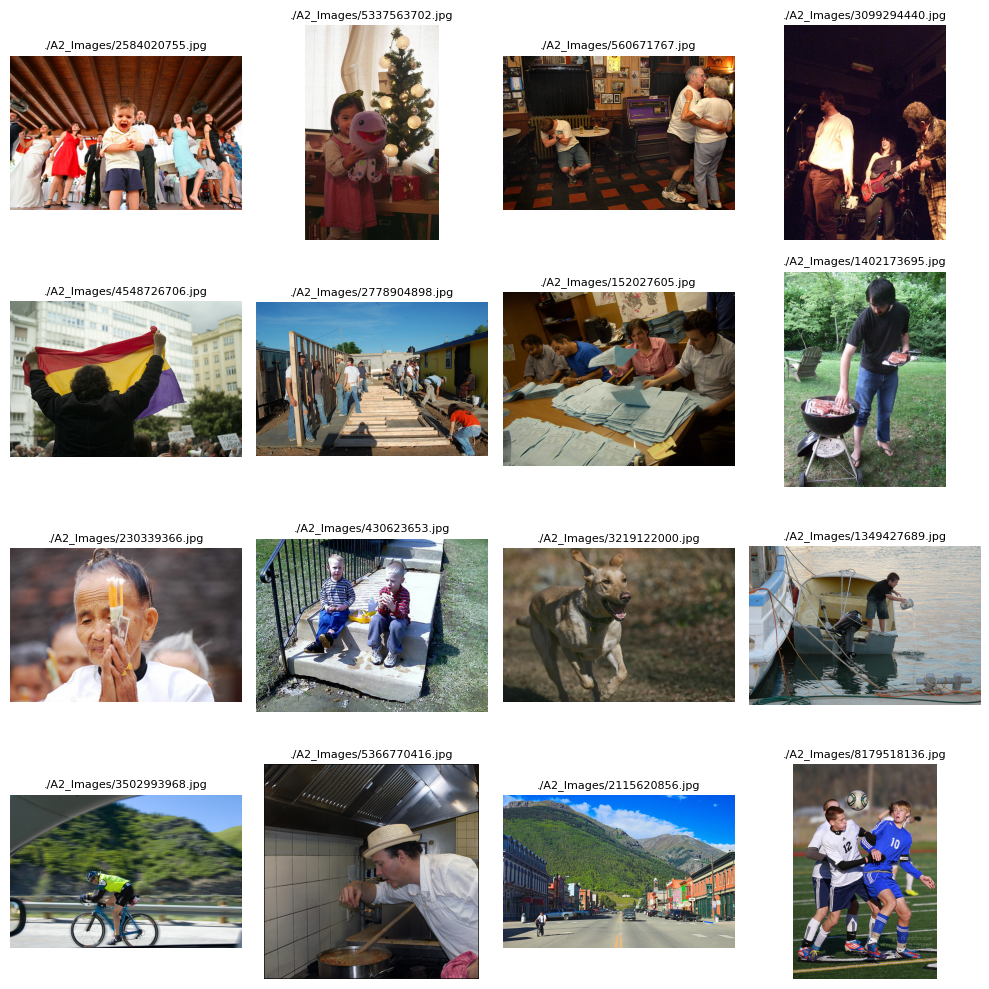

In [ ]:
# load images and labels 

labelSet = Counter()
dataDict = {}
vocab = set()

datasetLen = 0
with open("./A2_train_v3.jsonl", "r") as jsonFile:
	for line in jsonFile:
		datasetLen += 1
		loadedLine = json.loads(line)
		if loadedLine["Image_ID"] not in dataDict:
			dataDict[loadedLine["Image_ID"]] = []

		labelSet[loadedLine["Label"]] += 1

		hypo = [''.join(char for char in word if char.isalnum()) for word in loadedLine["Hypothesis"].lower().split()]
		vocab.update(hypo)

		dataDict[loadedLine["Image_ID"]].append((hypo, loadedLine["Label"]))

labelTuple = tuple(labelSet.keys())
vocab = list(vocab)

vocabIndex = {vocab[i]: i for i in range(len(vocab))}

print(f'Number of images {len(dataDict.keys())}')
print(f'Vocab length {len(vocabIndex)}')
print(f'hypothesis count {datasetLen}')
print(f'Dataset balance {labelSet}')

gridSize = 4
plt.figure(figsize=(10, 10)) 

for i in range(gridSize ** 2):
	image_file = './A2_Images/' + random.choice(list(dataDict.keys())) + '.jpg'
	img = mpimg.imread(image_file)

	plt.subplot(gridSize, gridSize, i + 1)
	plt.imshow(img)
	plt.title(image_file, fontsize=8)
	plt.axis('off') # Hide axes for cleaner image display

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## Loading the data

TODO

In [ ]:


# load the glove embeddings 

def getGlove():
  print('Downloading glove')
  subprocess.run(['wget', 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'])
  subprocess.run(['unzip', '-q glove.6B.zip'])

def generateMatrix(dim):
    print('parsing glove data')
    embeddingMatrix = np.zeros((len(vocab), dim))
    embeddedVocab = []
    
    with open(f'glove.6B.{dim}d.txt', encoding="utf-8") as gloveFile:
      for line in gloveFile:
        values = line.split()
        word = values[0]
    
        if word in vocab:
          embeddingMatrix[vocabIndex[word]] = np.asarray(values[1:], dtype='float32')
          embeddedVocab.append(word)

    print(f'embedded {len(embeddedVocab)} out of {len(vocab)}')
    return embeddingMatrix


embeddingDim = 200
embeddingMatrix = None

if not os.path.isfile(f'glove.6B.{embeddingDim}d.txt'):
  getGlove()

if os.path.isfile(f'embeddingMatrix.{embeddingDim}d.pkl'):
  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'rb') as f:
    embeddingMatrix = pickle.load(f)

  print('loaded matrix')
else:
  embeddingMatrix = generateMatrix(embeddingDim)

  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'ab') as f:
    pickle.dump(embeddingMatrix, f)

  print('saved matrix')

19573
9274
39129
Counter({'entailment': 19619, 'contradiction': 19510})
loaded matrix


## Creating the tensorflow dataset

TODO

In [40]:
maxLen = 128

X1array = []
X2array = []
YArray = []

for key, hypoAndLabels in dataDict.items():
	img = f'./A2_Images/{key}.jpg'

	for hypo, label in hypoAndLabels:
		label = tf.convert_to_tensor([labelTuple.index(label)])
		label.set_shape([1])

		hypo = [vocabIndex[word] for word in hypo]
		hypo = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([hypo], maxlen=maxLen)[0])
		hypo.set_shape([maxLen])

		X1array.append(img)
		X2array.append(hypo)
		YArray.append(label)

X1Numpy = np.array(X1array)
X2Numpy = np.array(X2array, dtype='uint16')
YNumpy = np.array(YArray, dtype='uint8')

dataset = tf.data.Dataset.from_tensor_slices(({'image': X1Numpy, 'text': X2Numpy}, YNumpy))

imageChannels = 3
imageRes = 224
patchesPerImage = 8

patchRes = int(imageRes / patchesPerImage) 
patchNum = patchesPerImage ** 2 * imageChannels 

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_image(img, channels=imageChannels, dtype=tf.float32)
	img = tf.image.resize(img, (imageRes, imageRes))

	return img

def getImageWrapper(x, y):
	img = tf.py_function(func=getImage, inp=[x['image']], Tout=tf.float32)
	img.set_shape([imageRes, imageRes, imageChannels])

	x['image'] = img 
	return x, y

dataset = dataset.map(getImageWrapper, num_parallel_calls=8)

testSize = int(datasetLen * 0.05)
valSize = int(datasetLen * 0.05)
trainSize = int(datasetLen - testSize - valSize)
batchSize = 100

def optimize(ds, name):
	ds = ds.batch(batchSize) 
	ds = ds.cache(name + 'dataset.cache') 
	ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
	
	return ds

def getTest(ds):
	ds = ds.take(testSize) 
	ds = optimize(ds, 'test')
	
	return ds

def getVal(ds):
	ds = ds.skip(testSize)
	ds = ds.take(valSize) 
	ds = optimize(ds, 'val')

	return ds

def getTrain(ds):
	ds = ds.skip(valSize + testSize)
	ds = ds.take(trainSize)
	ds = optimize(ds, 'train')

	return ds

testDS = getTest(dataset)
valDS = getVal(dataset)
trainDS = getTrain(dataset)


print(f"test data batches {tf.data.experimental.cardinality(testDS).numpy()}")
print(f"val data batches {tf.data.experimental.cardinality(valDS).numpy()}")
print(f"train data batches {tf.data.experimental.cardinality(trainDS).numpy()}")
print(f'ratios test:{testSize} val:{valSize} train:{trainSize}')


test data batches 20
val data batches 20
train data batches 353
ratios test:1956 val:1956 train:35217


In [39]:
# clear dataset cache

for f in os.listdir('./'):  
	if 'dataset.cache' in f:
		os.remove(f)

# Training

ToDo


In [ ]:
densSize = 256

@tf.keras.utils.register_keras_serializable()
class PositionEncoder(tf.keras.Layer):
	def __init__(self, patchRes, patchNum, name=None):
		super(PositionEncoder, self).__init__(name=name)
		self.patchRes = patchRes
		self.patchNum = patchNum
		w_init = tf.random_normal_initializer()
		classToken = w_init(shape=(1, patchNum), dtype=tf.float32)
		self.classToken = tf.Variable(initial_value=classToken, trainable=True)
		self.projection =tf.keras.layers.Dense(units=patchNum)
		self.positionEmbedding = tf.keras.layers.Embedding(input_dim=patchRes+1, output_dim=patchNum, mask_zero=True)

	def call(self, patch):
		batch = tf.shape(patch)[0]
		classToken = tf.tile(self.classToken, multiples = [batch, 1])
		classToken = tf.reshape(classToken, (batch, 1, self.patchNum))
		patchesEmbed = self.projection(patch)
		patchesEmbed = tf.concat([patchesEmbed, classToken], 1)
		positions = tf.range(start=0, limit=self.patchRes+1, delta=1)
		positionsEmbed = self.positionEmbedding(positions)
		encoded = patchesEmbed + positionsEmbed
		return encoded

@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Layer):
	def __init__(self, dim, heads=4, dropout=0.1, name=None):
		super(Transformer, self).__init__(name=name)
		self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.attn = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout)
		self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.dense1 = tf.keras.layers.Dense(dim * 2, activation='relu')
		self.dense2 = tf.keras.layers.Dense(dim, activation='relu')
		self.drop = tf.keras.layers.Dropout(dropout)

	def call(self, inputLayers):
		attention = self.attn(inputLayers, inputLayers)
		attention = tf.keras.layers.Add()([attention, inputLayers])
		attention = self.norm1(attention)

		mlp = self.drop(attention)
		mlp = self.dense1(mlp)
		mlp = self.drop(mlp)
		mlp = self.dense2(mlp)
		mlp = tf.keras.layers.Add()([mlp, attention])
		mlp = self.norm2(mlp)

		return mlp

# Image Encoder 
inputImageLayer = tf.keras.layers.Input(shape=(imageRes, imageRes, imageChannels), name='image')

vtiBaseModel = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")

baseModel.trainable = False
imageOut = baseModel(inputImageLayer, training=False)
imageOut = tf.keras.layers.GlobalMaxPooling1D(name='imageOut')(imageOut)

# Text Encoder 
inputTextLayer = tf.keras.layers.Input(shape=(maxLen,), name='text')

embeddingText = tf.keras.layers.Embedding(len(vocab), embeddingDim, weights=[embeddingMatrix], trainable=False)(inputTextLayer)
reshapeText = tf.keras.layers.Reshape((embeddingDim, maxLen))(embeddingText)
textOut = PositionEncoder(embeddingDim, maxLen, name='embeddingText')(reshapeText)

textOut = Transformer(maxLen)(textOut)
textOut = Transformer(maxLen)(textOut)

textOut = tf.keras.layers.GlobalMaxPooling1D(name='textOut')(textOut)

# Entanglement decoder 
decoder = tf.keras.layers.Concatenate(name='decoderInput')([imageOut, textOut])

decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)
# decoder = tf.keras.layers.Dense(densSize, activation='relu')(dense)

decoderOutput = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(decoder)

model = tf.keras.Model(inputs=[inputImageLayer, inputTextLayer], outputs=decoderOutput)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy', 'f1_score']
)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 128, 200)  │  1,854,800 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 200, 128)  │          0 │ embedding_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingText       │ (None, 201, 128)  │     42,240 │ reshape_6[0][0]   │
│ (PositionEncoder)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_12      │ (None, 201, 128)  │    330,240 │ embeddingText[0]… │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 197, 768)  │ 85,798,656 │ image[0][0]       │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_13      │ (None, 201, 128)  │    330,240 │ transformer_12[0… │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imageOut            │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ textOut             │ (None, 128)       │          0 │ transformer_13[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoderInput        │ (None, 896)       │          0 │ imageOut[0][0],   │
│ (Concatenate)       │                   │            │ textOut[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 256)       │    229,632 │ decoderInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 256)       │     65,792 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dense_48[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,651,857 (338.18 MB)

 Trainable params: 998,401 (3.81 MB)

 Non-trainable params: 87,653,456 (334.37 MB)

In [46]:
# Training

history = model.fit(
  trainDS,
	validation_data=valDS,
  epochs=16,
  batch_size=batchSize
)

Epoch 1/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 133s 345ms/step - accuracy: 0.5704 - f1_score: 0.6645 - loss: 0.6837 - val_accuracy: 0.6355 - val_f1_score: 0.6707 - val_loss: 0.6406
Epoch 2/16


2025-10-12 01:19:35.978711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-12 01:19:35.984048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 234ms/step - accuracy: 0.6457 - f1_score: 0.6645 - loss: 0.6227 - val_accuracy: 0.6288 - val_f1_score: 0.6707 - val_loss: 0.6378
Epoch 3/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.6687 - f1_score: 0.6645 - loss: 0.5997 - val_accuracy: 0.6590 - val_f1_score: 0.6707 - val_loss: 0.6201
Epoch 4/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.6822 - f1_score: 0.6645 - loss: 0.5831 - val_accuracy: 0.6544 - val_f1_score: 0.6707 - val_loss: 0.6117
Epoch 5/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.6997 - f1_score: 0.6645 - loss: 0.5698 - val_accuracy: 0.6462 - val_f1_score: 0.6707 - val_loss: 0.6242
Epoch 6/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.7034 - f1_score: 0.6645 - loss: 0.5590 - val_accuracy: 0.6805 - val_f1_score: 0.6707 - val_loss: 0.5985
Epoch 7/16
353/353 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.7139 - f1_score: 0.6645 - loss: 0.5494 - val_accuracy: 0.6754 - val_f1_score:

KeyboardInterrupt: 

In [ ]:
model.save('a2-models/pretrained-image-b16.keras')

In [136]:
tf.keras.backend.clear_session(free_memory=True)
import gc 
gc.collect()

0

In [5]:
vitBackboneImport = tf.keras.models.load_model('vit.keras')

In [21]:


vitBackbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet21k")

vitBackbone.save('vit.keras')

In [ ]:
clip.summary()